In [3]:
import numpy as np
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
from ase.units import Bohr,Hartree
from gpaw.wavefunctions.pw import PWDescriptor
from gpaw.kpt_descriptor import KPointDescriptor
from itertools import product

# Part 1: Ground state calculation
atoms = bulk('Si', 'diamond', a=5.431)   # Generate diamond crystal structure for silicon

calc = GPAW(mode=PW(400),
            kpts={'density': 5.0, 'gamma': True},
            parallel={'band': 1, 'domain': 1},
            xc='PBE',
            occupations=FermiDirac(0.001),
            setups='sg15')  # use small FD smearing

atoms.set_calculator(calc)
atoms.get_potential_energy()  # get ground state density

# Restart Calculation with fixed density and dense kpoint sampling
calc.set(kpts={'density': 15.0, 'gamma': False},  # dense kpoint sampling
         fixdensity=True)
calc.diagonalize_full_hamiltonian(nbands=70)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.4.0
 |___|_|             

User:   yzhumagulov@cpqm1
Date:   Wed Feb 13 15:49:23 2019
Arch:   x86_64
Pid:    10110
Python: 3.7.0
gpaw:   /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/ase (version 3.16.2)
numpy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/numpy (version 1.15.1)
scipy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/scipy (version 1.1.0)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {density: 5.0,
         gamma: True}
  mode: {ecut: 400.0,
         name: pw}
  occupations: {name: fermi-dirac,
                width: 0.001}
  setups: sg15
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Norm-conservin

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


Creating initial wave functions:
  8 bands from LCAO basis set

                    
                    
                    
                    
           Si       
                    
       Si           
                    
                    
                    
                    

Positions:
   0 Si     0.000000    0.000000    0.000000    ( 0.0000,  0.0000,  0.0000)
   1 Si     1.357750    1.357750    1.357750    ( 0.0000,  0.0000,  0.0000)

Unit cell:
           periodic     x           y           z      points  spacing
  1. axis:    yes    0.000000    2.715500    2.715500    14     0.2240
  2. axis:    yes    2.715500    0.000000    2.715500    14     0.2240
  3. axis:    yes    2.715500    2.715500    0.000000    14     0.2240

  Lengths:   3.840297   3.840297   3.840297
  Angles:   60.000000  60.000000  60.000000

Effective grid spacing dv^(1/3) = 0.2444

                     log10-error:    total        iterations:
           time      wfs    density  energy       f

----------------------| Time: 1587.699s


In [4]:
#объем элементарной ячейки
volume = np.abs(np.linalg.det(calc.wfs.gd.cell_cv)) 
#редуцированная зона Бриллюэна
K=calc.get_ibz_k_points();NK=K.shape[0] 
#веса точек редуцированной зоны Бриллюэна
wk=calc.get_k_point_weights()
#энергия орбиталей Кона-Шэма
EK=[calc.get_eigenvalues(k) for k in range(NK)] 
EK=np.array(EK)/Hartree
#Число валентных электронов
nvalence=calc.occupations.nvalence
nbands=calc.get_number_of_bands()
#Валентные зоны
vb=np.arange(0,nvalence/2,dtype=int)
#Зоны проводимости
cb=np.arange(nvalence/2,nbands,dtype=int)
#Индексы комбинаций лптических электрон-дырочных пар
indexes=[(k,v,c) for k,v,c in product(range(NK),range(len(vb)),range(len(cb)))]
NH=len(indexes)

Расчитаем 
$$\varepsilon_M(\omega)=1-\lim_{q\to 0,G\to 0}\frac{4\pi}{|q+G|^{2}}\sum_{vc}\sum_{k\in IBZ}\frac{|<vk|e^{i(q+G)r}|ck>|^{2}}{\omega+i\eta+\epsilon_{vk}-\epsilon_{ck}}$$

$$\lim_{q\to 0,G\to 0} <vk|e^{i(q+G)r}|ck>=q\frac{<vk|G|ck>}{\epsilon_{ck}-\epsilon_{vk}}$$

$$\varepsilon_M(\omega)=1-4\pi\sum_{vc}\sum_{k\in IBZ}\frac{|<vk|G|ck>|^{2}}{(\omega+i\eta+\epsilon_{vk}-\epsilon_{ck})(\epsilon_{ck}-\epsilon_{vk})^{2}}$$

In [5]:
velocity=np.zeros((NH,3),dtype=np.complex)
omega=np.linspace(0,20,20000)/Hartree;eta=0.05/Hartree
chi=np.zeros(omega.size,dtype=np.complex)
for indx in range(NH):
    k,v,c=indexes[indx]
    wf1=calc.wfs.get_wave_function_array(n=vb[v],k=k,s=0,realspace=False)
    wf2=calc.wfs.get_wave_function_array(n=cb[c],k=k,s=0,realspace=False)
    G_=calc.wfs.pd.get_reciprocal_vectors(q=k,add_q=True)
    for i in range(3):
        velocity[indx,i]=calc.wfs.pd.integrate(wf1,G_[:,i]*wf2)/(EK[k,cb[c]]-EK[k,vb[v]])
    chi+=wk[k]*np.linalg.norm(velocity[indx])**2/(omega+1j*eta-EK[k,cb[c]]+EK[k,vb[v]])/volume
epsilon=1-4*np.pi*chi

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

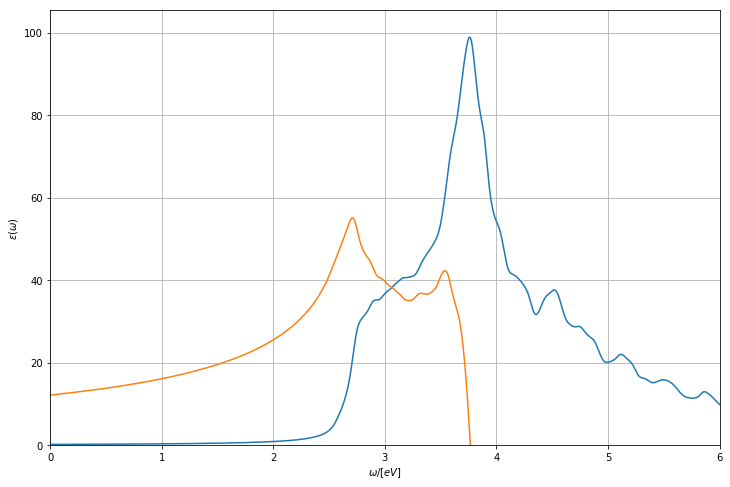

In [12]:
plt.figure(figsize=(12,8))
plt.plot(omega*Hartree,epsilon.imag)
plt.plot(omega*Hartree,epsilon.real)
plt.xlabel('$\\omega / [eV]$')
plt.ylabel('$\\epsilon(\\omega)$')
plt.xlim([0,6])
plt.ylim([0,None])
plt.grid()

Сравним с 

<b>M. Gajdoš, K. Hummer, G. Kresse, J. Furthmüller and F. Bechstedt, Linear optical properties in the projected-augmented wave methodology, Phys. Rev. B 73, 045112 (2006).</b>

<img src="https://wiki.fysik.dtu.dk/gpaw/_images/silicon_ABS.png">

Макроскопическая диэлектрическая константа

In [14]:
epsilon[0].real

12.101852045764588

Экспериментальное значение 11.900000

Проверим f-sum

In [15]:
np.trapz(epsilon.imag*omega,omega)/(nvalence/volume)/(2*np.pi**2)

1.5723747281713532

Получается $\frac{\pi}{2}$ вместо 1